# John's Exponents: Lattice Resolution at the Black Hole

**Purpose:** Examine the bfloat16 exponent distribution across John's 2560 dimensions to understand the lattice coarseness where the biggest black hole lives.

---

## The Hypothesis

Each bfloat16 coordinate has an 8-bit exponent that determines the ULP (Unit in Last Place)—the smallest distinguishable step at that position. Larger exponents mean coarser grids.

If the frozen smoke formed through **coalescence** during training, then:
- Dimensions with large exponents (coarse) are where tokens get "snapped together"
- Dimensions with small exponents (fine) allow more discrimination

The distribution of exponents across John's 2560 dimensions tells us the *shape* of his lattice cell.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

# Paths
DATA_DIR = Path("../../../tensors/Qwen3-4B-Instruct-2507")

# Load data
W = load_file(DATA_DIR / "W_unembed.safetensors")['W'].view(torch.bfloat16)
masks = load_file(DATA_DIR / "masks.safetensors")
neighborhood_mask = masks['neighborhood_mask']

print(f"W shape: {W.shape}")
print(f"Neighborhood tokens: {neighborhood_mask.sum().item():,}")

W shape: torch.Size([151936, 2560])
Neighborhood tokens: 2,212


In [2]:
# Find John (the 814-token black hole)
neighborhood_indices = torch.where(neighborhood_mask)[0]
W_neighborhood = W[neighborhood_indices]

unique_bits, inverse_indices, counts = torch.unique(
    W_neighborhood.view(torch.uint16).to(torch.int32), dim=0,
    return_inverse=True, return_counts=True
)

# John is the biggest black hole
john_idx = counts.argmax().item()
john_count = counts[john_idx].item()

# Get John's vector in bfloat16
john_bits = unique_bits[john_idx]  # [2560] as int32 (from uint16)
john_bf16 = john_bits.to(torch.uint16).view(torch.bfloat16)  # [2560]

print(f"John (biggest black hole):")
print(f"  Token count: {john_count}")
print(f"  Vector shape: {john_bf16.shape}")
print(f"  L2 norm: {torch.norm(john_bf16.float()):.6f}")

John (biggest black hole):
  Token count: 814
  Vector shape: torch.Size([2560])
  L2 norm: 0.370917


## Extract Exponents

bfloat16 format: `[sign (1 bit)][exponent (8 bits)][mantissa (7 bits)]`

Exponent is bits 7-14 (0-indexed), extracted as `(bits >> 7) & 0xFF`.

The ULP at a given exponent E is: `2^(E - 127 - 7) = 2^(E - 134)`

In [3]:
def extract_exponents(bf16_tensor):
    """Extract 8-bit exponent field from bfloat16 values."""
    bits = bf16_tensor.view(torch.uint16).to(torch.int32)
    exponents = (bits >> 7) & 0xFF
    return exponents

def exponent_to_ulp(exponent):
    """Convert exponent to ULP value."""
    # ULP = 2^(E - 127 - 7) = 2^(E - 134)
    # For E=0 (subnormal), effective E=1
    e = np.maximum(exponent, 1)
    return 2.0 ** (e - 134)

# Extract John's exponents
john_exponents = extract_exponents(john_bf16).numpy()

print(f"John's exponents:")
print(f"  Shape: {john_exponents.shape}")
print(f"  Range: [{john_exponents.min()}, {john_exponents.max()}]")
print(f"  Mean: {john_exponents.mean():.2f}")
print(f"  Median: {np.median(john_exponents):.2f}")
print(f"  Std: {john_exponents.std():.2f}")

John's exponents:
  Shape: (2560,)
  Range: [107, 123]
  Mean: 118.07
  Median: 118.00
  Std: 1.69


In [4]:
# Convert to ULP values
john_ulps = exponent_to_ulp(john_exponents)

print(f"John's ULPs:")
print(f"  Range: [{john_ulps.min():.2e}, {john_ulps.max():.2e}]")
print(f"  Ratio (max/min): {john_ulps.max() / john_ulps.min():.1f}x")
print(f"  Mean: {john_ulps.mean():.2e}")
print(f"  Median: {np.median(john_ulps):.2e}")

John's ULPs:
  Range: [7.45e-09, 4.88e-04]
  Ratio (max/min): 65536.0x
  Mean: 2.70e-05
  Median: 1.53e-05


## Exponent Distribution

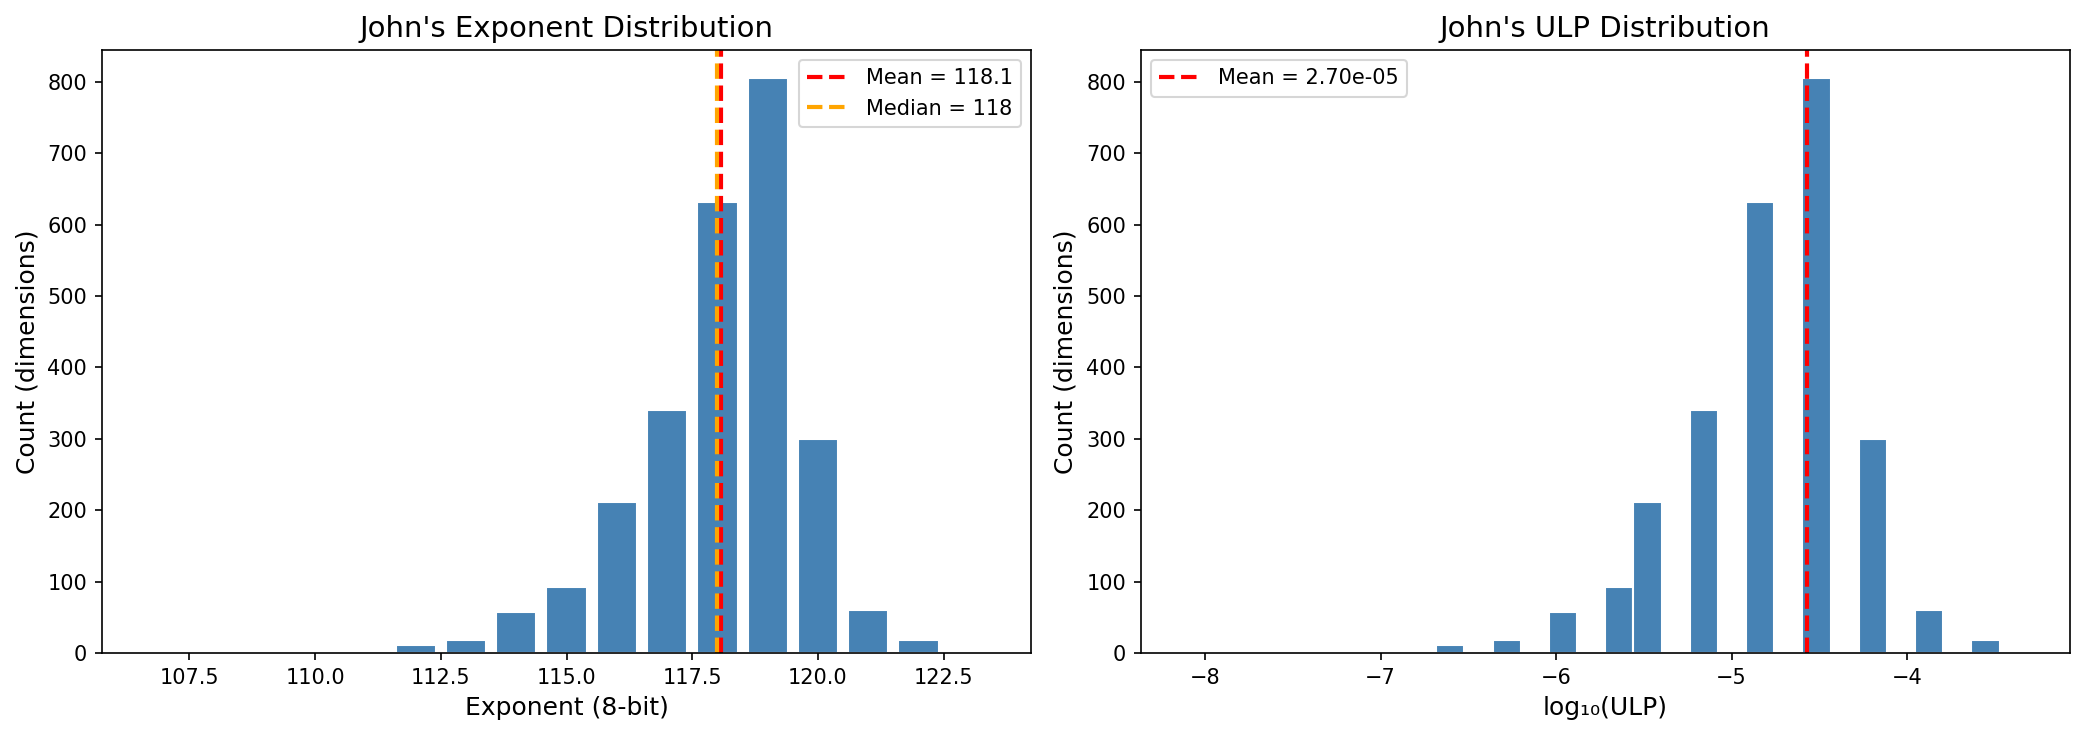

In [5]:
# Histogram of exponents
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=150)

# Exponent histogram
ax = axes[0]
unique_exps, exp_counts = np.unique(john_exponents, return_counts=True)
ax.bar(unique_exps, exp_counts, color='steelblue', edgecolor='white')
ax.axvline(john_exponents.mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean = {john_exponents.mean():.1f}')
ax.axvline(np.median(john_exponents), color='orange', linestyle='--', linewidth=2,
           label=f'Median = {np.median(john_exponents):.0f}')
ax.set_xlabel('Exponent (8-bit)', fontsize=12)
ax.set_ylabel('Count (dimensions)', fontsize=12)
ax.set_title("John's Exponent Distribution", fontsize=14)
ax.legend()

# ULP histogram (log scale)
ax = axes[1]
ax.hist(np.log10(john_ulps), bins=30, color='steelblue', edgecolor='white')
ax.axvline(np.log10(john_ulps.mean()), color='red', linestyle='--', linewidth=2,
           label=f'Mean = {john_ulps.mean():.2e}')
ax.set_xlabel('log₁₀(ULP)', fontsize=12)
ax.set_ylabel('Count (dimensions)', fontsize=12)
ax.set_title("John's ULP Distribution", fontsize=14)
ax.legend()

plt.tight_layout()
plt.savefig('../../../notebooks/analysis/john_exponents.png', dpi=150, bbox_inches='tight')
plt.show()

In [6]:
# Detailed breakdown by exponent
print(f"{'Exponent':>10} {'Count':>10} {'Pct':>10} {'ULP':>15} {'Interpretation':>20}")
print("-" * 70)

for exp in sorted(unique_exps):
    count = (john_exponents == exp).sum()
    pct = count / len(john_exponents) * 100
    ulp = exponent_to_ulp(exp)
    
    # Interpretation
    if exp < 120:
        interp = 'TINY (< 1e-4)'
    elif exp < 124:
        interp = 'small'
    elif exp < 127:
        interp = 'medium'
    elif exp == 127:
        interp = 'unit scale'
    else:
        interp = 'LARGE (> 1)'
    
    print(f"{exp:>10} {count:>10} {pct:>9.1f}% {ulp:>15.2e} {interp:>20}")

  Exponent      Count        Pct             ULP       Interpretation
----------------------------------------------------------------------
       107          2       0.1%        7.45e-09        TINY (< 1e-4)
       108          1       0.0%        1.49e-08        TINY (< 1e-4)
       110          2       0.1%        5.96e-08        TINY (< 1e-4)
       111          2       0.1%        1.19e-07        TINY (< 1e-4)
       112         12       0.5%        2.38e-07        TINY (< 1e-4)
       113         18       0.7%        4.77e-07        TINY (< 1e-4)
       114         58       2.3%        9.54e-07        TINY (< 1e-4)
       115         93       3.6%        1.91e-06        TINY (< 1e-4)
       116        212       8.3%        3.81e-06        TINY (< 1e-4)
       117        341      13.3%        7.63e-06        TINY (< 1e-4)
       118        632      24.7%        1.53e-05        TINY (< 1e-4)
       119        805      31.4%        3.05e-05        TINY (< 1e-4)
       120        3

## Comparison: John's Values vs Exponents

Let's see how John's actual coordinate values relate to the exponents.

In [7]:
# John's coordinate values
john_values = john_bf16.float().numpy()

print(f"John's coordinate values:")
print(f"  Range: [{john_values.min():.6f}, {john_values.max():.6f}]")
print(f"  Mean: {john_values.mean():.6f}")
print(f"  Std: {john_values.std():.6f}")
print(f"  % positive: {(john_values > 0).mean() * 100:.1f}%")
print(f"  % negative: {(john_values < 0).mean() * 100:.1f}%")
print(f"  % zero: {(john_values == 0).mean() * 100:.1f}%")

John's coordinate values:
  Range: [-0.080078, 0.049805]
  Mean: -0.000058
  Std: 0.007331
  % positive: 50.4%
  % negative: 49.6%
  % zero: 0.0%


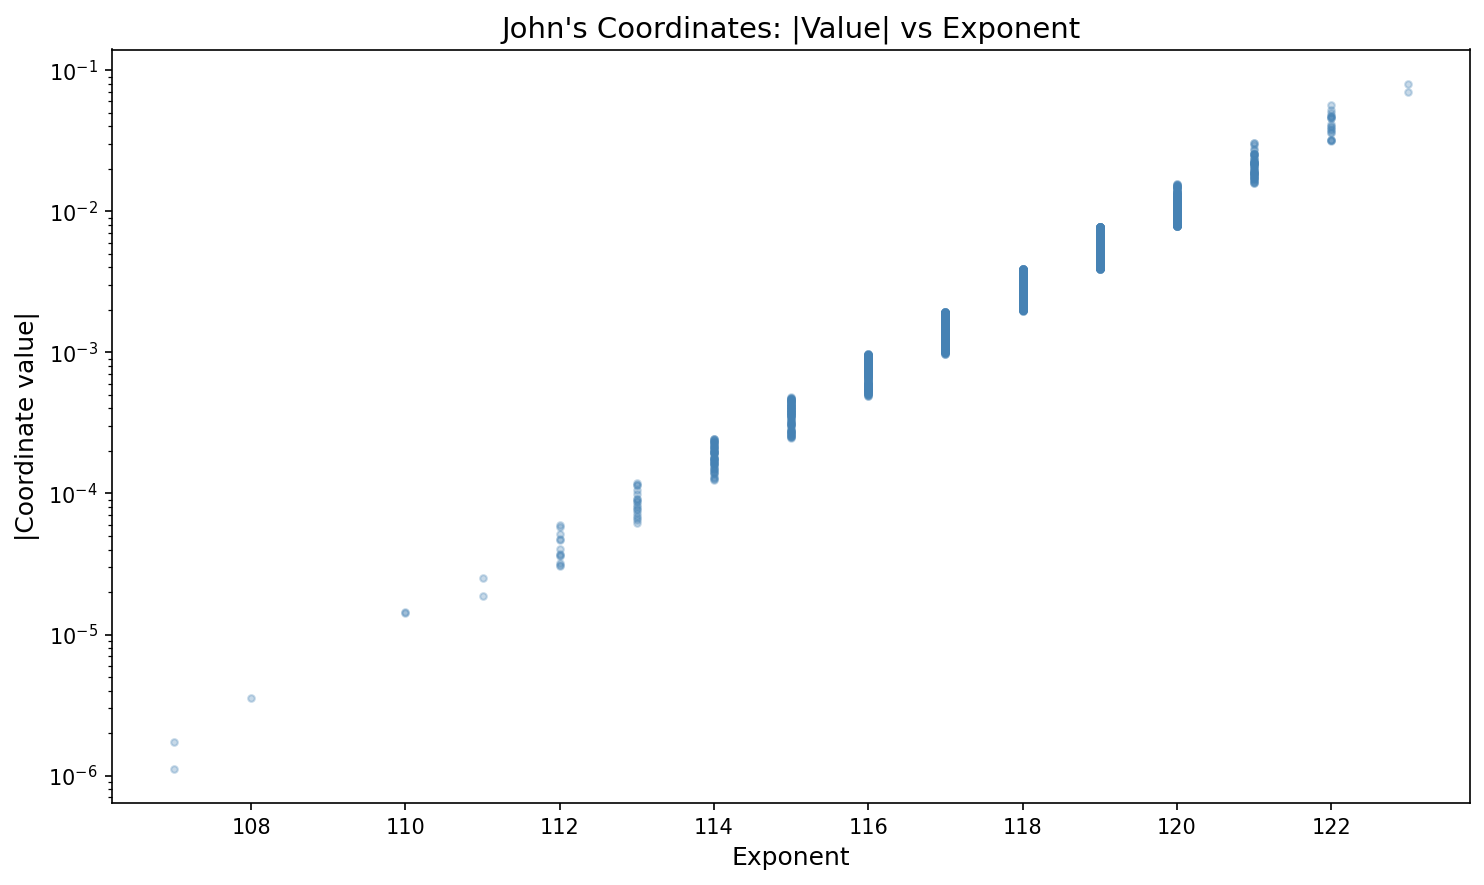

In [8]:
# Scatter: |value| vs exponent
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

ax.scatter(john_exponents, np.abs(john_values), alpha=0.3, s=10, c='steelblue')
ax.set_xlabel('Exponent', fontsize=12)
ax.set_ylabel('|Coordinate value|', fontsize=12)
ax.set_title("John's Coordinates: |Value| vs Exponent", fontsize=14)
ax.set_yscale('log')

plt.tight_layout()
plt.savefig('../../../notebooks/analysis/john_value_vs_exponent.png', dpi=150, bbox_inches='tight')
plt.show()

## The "Stickiness" of Each Dimension

The ULP ratio (max/min) tells us how anisotropic the lattice cell is. If it's 1, all dimensions have equal resolution. If it's large, some dimensions are much coarser than others—those are the "sticky" dimensions where coalescence happens.

In [9]:
# Rank dimensions by coarseness
dim_order = np.argsort(john_exponents)[::-1]  # Coarsest first

print("Top 20 COARSEST dimensions (most sticky):")
print(f"{'Rank':>5} {'Dim':>6} {'Exp':>5} {'ULP':>12} {'Value':>12}")
print("-" * 45)
for i, dim in enumerate(dim_order[:20]):
    print(f"{i+1:>5} {dim:>6} {john_exponents[dim]:>5} {john_ulps[dim]:>12.2e} {john_values[dim]:>12.6f}")

print()
print("Top 20 FINEST dimensions (least sticky):")
print(f"{'Rank':>5} {'Dim':>6} {'Exp':>5} {'ULP':>12} {'Value':>12}")
print("-" * 45)
for i, dim in enumerate(dim_order[-20:][::-1]):
    print(f"{i+1:>5} {dim:>6} {john_exponents[dim]:>5} {john_ulps[dim]:>12.2e} {john_values[dim]:>12.6f}")

Top 20 COARSEST dimensions (most sticky):
 Rank    Dim   Exp          ULP        Value
---------------------------------------------
    1     32   123     4.88e-04    -0.070312
    2    163   123     4.88e-04    -0.080078
    3     56   122     2.44e-04     0.031738
    4    156   122     2.44e-04     0.040039
    5    493   122     2.44e-04    -0.032227
    6    270   122     2.44e-04     0.046631
    7     75   122     2.44e-04     0.031982
    8    130   122     2.44e-04    -0.037842
    9   1145   122     2.44e-04    -0.045654
   10    321   122     2.44e-04     0.039551
   11     18   122     2.44e-04     0.045898
   12     67   122     2.44e-04     0.049805
   13     13   122     2.44e-04    -0.047607
   14     44   122     2.44e-04    -0.038086
   15    199   122     2.44e-04    -0.056641
   16    329   122     2.44e-04    -0.031494
   17     59   122     2.44e-04    -0.047607
   18      3   122     2.44e-04     0.036621
   19    780   122     2.44e-04    -0.035889
   20    161

## Summary

In [10]:
print("=" * 60)
print("JOHN'S EXPONENTS SUMMARY")
print("=" * 60)
print()
print(f"John (814-token black hole):")
print(f"  L2 norm: {torch.norm(john_bf16.float()):.6f}")
print()
print(f"EXPONENT DISTRIBUTION:")
print(f"  Range: [{john_exponents.min()}, {john_exponents.max()}]")
print(f"  Mean: {john_exponents.mean():.2f}")
print(f"  Median: {np.median(john_exponents):.0f}")
print(f"  Std: {john_exponents.std():.2f}")
print()
print(f"ULP (LATTICE RESOLUTION):")
print(f"  Coarsest: {john_ulps.max():.2e}")
print(f"  Finest: {john_ulps.min():.2e}")
print(f"  Anisotropy ratio: {john_ulps.max() / john_ulps.min():.1f}x")
print()
print(f"INTERPRETATION:")
n_coarse = (john_exponents >= 125).sum()
n_fine = (john_exponents <= 120).sum()
print(f"  Coarse dimensions (exp >= 125): {n_coarse} ({n_coarse/2560*100:.1f}%)")
print(f"  Fine dimensions (exp <= 120): {n_fine} ({n_fine/2560*100:.1f}%)")

JOHN'S EXPONENTS SUMMARY

John (814-token black hole):
  L2 norm: 0.370917

EXPONENT DISTRIBUTION:
  Range: [107, 123]
  Mean: 118.07
  Median: 118
  Std: 1.69

ULP (LATTICE RESOLUTION):
  Coarsest: 4.88e-04
  Finest: 7.45e-09
  Anisotropy ratio: 65536.0x

INTERPRETATION:
  Coarse dimensions (exp >= 125): 0 (0.0%)
  Fine dimensions (exp <= 120): 2478 (96.8%)
